# Classificador de Imagens: Cães vs. Gatos com PyTorch

**Objetivo:** Esta é uma versão do projeto reescrita com a biblioteca PyTorch, compatível com as versões mais recentes de Python (como a 3.13).

## ⚙️ Configuração do Ambiente Local (Instruções Iniciais)


2.  Instale as bibliotecas necessárias com o comando:
    ```bash
    pip install torch torchvision torchaudio scikit-learn matplotlib jupyter notebook
    ```


---
## Etapa 1: Organização dos Dados e Criação dos Datasets

A primeira parte, que organiza os arquivos em pastas, é a mesma. Ela não depende da biblioteca de deep learning.

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

original_train_dir = 'train'
base_dir = 'data/cats_vs_dogs_split'

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.makedirs(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir)

for d in [train_dir, validation_dir, test_dir]:
    os.makedirs(os.path.join(d, 'cats'))
    os.makedirs(os.path.join(d, 'dogs'))

all_filenames = os.listdir(original_train_dir)
cat_filenames = [f for f in all_filenames if f.startswith('cat')]
dog_filenames = [f for f in all_filenames if f.startswith('dog')]

train_cats, test_val_cats = train_test_split(cat_filenames, test_size=0.3, random_state=42)
val_cats, test_cats = train_test_split(test_val_cats, test_size=0.5, random_state=42)
train_dogs, test_val_dogs = train_test_split(dog_filenames, test_size=0.3, random_state=42)
val_dogs, test_dogs = train_test_split(test_val_dogs, test_size=0.5, random_state=42)

def copy_files(filenames, class_name, dest_dir):
    for filename in filenames:
        src = os.path.join(original_train_dir, filename)
        dst = os.path.join(dest_dir, class_name, filename)
        shutil.copyfile(src, dst)

copy_files(train_cats, 'cats', train_dir)
copy_files(val_cats, 'cats', validation_dir)
copy_files(test_cats, 'cats', test_dir)
copy_files(train_dogs, 'dogs', train_dir)
copy_files(val_dogs, 'dogs', validation_dir)
copy_files(test_dogs, 'dogs', test_dir)

print("Organização de arquivos concluída.")

## Etapa 2: Pré-processamento e Carregamento de Dados (PyTorch)

Foi usado `torchvision.transforms` para definir o pré-processamento e o `ImageFolder` com `DataLoader` para carregar os dados.

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMG_SIZE = 150
BATCH_SIZE = 32

# Transformações para o conjunto de treino (com Data Augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(), # Converte para tensor e normaliza para [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normaliza para [-1, 1]
])

# Transformações para os conjuntos de validação e teste (sem augmentation)
test_val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Criar os Datasets com ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(validation_dir, transform=test_val_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_val_transforms)

# Criar os DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Classes encontradas: {train_dataset.classes}")
print(f"Mapeamento de classes: {train_dataset.class_to_idx}")

Classes encontradas: ['cats', 'dogs']
Mapeamento de classes: {'cats': 0, 'dogs': 1}


## Etapa 3: Construção do Modelo (CNN com PyTorch)

A rede foi definida como uma classe que herda de `torch.nn.Module`.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Bloco 1: 3x150x150 -> 32x75x75
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bloco 2: 32x75x75 -> 64x37x37
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bloco 3: 64x37x37 -> 128x18x18
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Camadas densas
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        
        x = x.view(-1, 128 * 18 * 18)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        # Retorna o logit bruto (sem sigmoid), pois a função de perda agora cuida disso.
        x = self.fc2(x) 
        return x

# Instanciar o modelo e verificar o dispositivo (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
print(f"Modelo movido para o dispositivo: {device}")
print(model)

Modelo movido para o dispositivo: cpu
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=41472, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)


## Etapa 4: Treinamento do Modelo

Foi definida a função de perda (criterion), o otimizador e o loop de treinamento explícito.

In [12]:
import torch.optim as optim
from tqdm import tqdm # Usando a versão de texto padrão para garantir a saída

# --- ALTERAÇÃO 1 AQUI: Usar a versão estável da função de perda ---
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- ALTERAÇÃO 2 AQUI: Aumentei as épocas para 20 ---
NUM_EPOCHS = 10

# Listas para guardar o histórico de perda e acurácia
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Loop de treinamento
for epoch in range(NUM_EPOCHS):
    print(f"Iniciando Época {epoch+1}/{NUM_EPOCHS}...")
    
    # --- Fase de Treinamento ---
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # Usando enumerate para o feedback manual
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        # Como a saída agora é logit, aplicamos sigmoid aqui APENAS para calcular a acurácia
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        # Imprime o feedback a cada 50 lotes
        if batch_idx % 50 == 49:
            print(f'  [Época {epoch+1}, Lote {batch_idx + 1}/{len(train_loader)}] Processado...')

    epoch_train_loss = running_loss / total_samples
    epoch_train_acc = correct_predictions / total_samples
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)

    # --- Fase de Validação ---
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)
            
    epoch_val_loss = running_loss / total_samples
    epoch_val_acc = correct_predictions / total_samples
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)
    
    print(f"\nFIM DA ÉPOCA {epoch+1}/{NUM_EPOCHS} -> "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}\n"
          f"{'-'*50}")

Iniciando Época 1/10...
  [Época 1, Lote 50/547] Processado...
  [Época 1, Lote 100/547] Processado...
  [Época 1, Lote 150/547] Processado...
  [Época 1, Lote 200/547] Processado...
  [Época 1, Lote 250/547] Processado...
  [Época 1, Lote 300/547] Processado...
  [Época 1, Lote 350/547] Processado...
  [Época 1, Lote 400/547] Processado...
  [Época 1, Lote 450/547] Processado...
  [Época 1, Lote 500/547] Processado...

FIM DA ÉPOCA 1/10 -> Train Loss: 0.6331, Train Acc: 0.6326 | Val Loss: 0.5482, Val Acc: 0.7157
--------------------------------------------------
Iniciando Época 2/10...
  [Época 2, Lote 50/547] Processado...
  [Época 2, Lote 100/547] Processado...
  [Época 2, Lote 150/547] Processado...
  [Época 2, Lote 200/547] Processado...
  [Época 2, Lote 250/547] Processado...
  [Época 2, Lote 300/547] Processado...
  [Época 2, Lote 350/547] Processado...
  [Época 2, Lote 400/547] Processado...
  [Época 2, Lote 450/547] Processado...
  [Época 2, Lote 500/547] Processado...

FIM DA

### Visualização dos Resultados do Treinamento

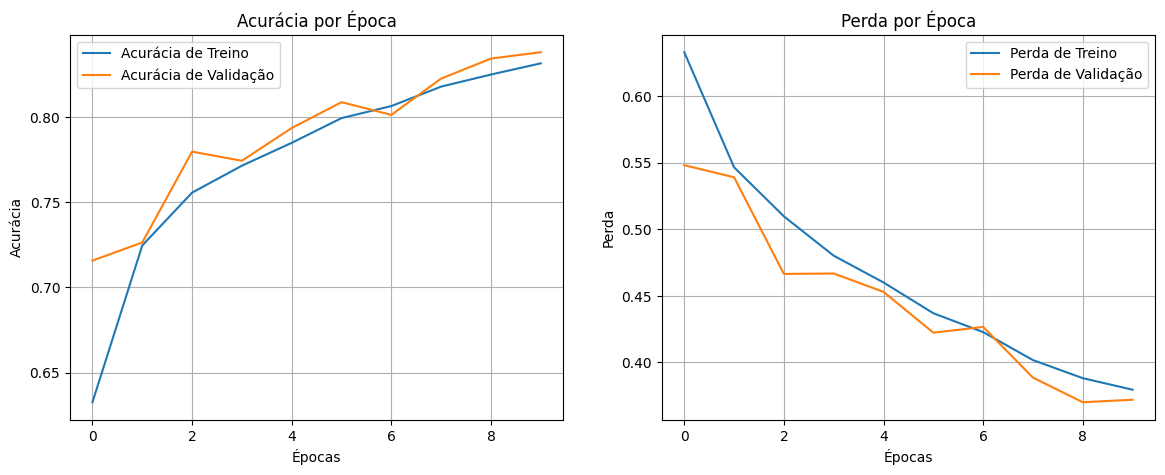

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Gráfico de Acurácia
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Acurácia de Treino')
plt.plot(history['val_acc'], label='Acurácia de Validação')
plt.title('Acurácia por Época')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

# Gráfico de Perda
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Perda de Treino')
plt.plot(history['val_loss'], label='Perda de Validação')
plt.title('Perda por Época')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)

plt.show()

## Etapa 5: Avaliação do Modelo

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        preds = (outputs > 0.5).cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

print("Relatório de Classificação:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

print("Matriz de Confusão:")
print(confusion_matrix(all_labels, all_preds))

Relatório de Classificação:
              precision    recall  f1-score   support

        cats       0.77      0.91      0.84      1875
        dogs       0.89      0.74      0.81      1875

    accuracy                           0.82      3750
   macro avg       0.83      0.82      0.82      3750
weighted avg       0.83      0.82      0.82      3750

Matriz de Confusão:
[[1708  167]
 [ 496 1379]]


## Etapa 6: Teste com Novas Imagens

In [ ]:
from PIL import Image
import requests
import torch
import matplotlib.pyplot as plt


def classify_new_image(source):
    try:
        if source.startswith('http'):
            response = requests.get(source, stream=True)
            response.raise_for_status()
            img = Image.open(response.raw).convert('RGB')
        else:
            img = Image.open(source).convert('RGB')
    except Exception as e:
        print(f"Erro ao carregar a imagem: {e}")
        return

    # Aplica as mesmas transformações do conjunto de teste
    img_transformed = test_val_transforms(img)
    # Adiciona uma dimensão de batch
    img_batch = img_transformed.unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(img_batch)
        
        # Convertendo o logit (saída bruta) para uma probabilidade (0 a 1)
        # usando a função sigmoide.
        prob = torch.sigmoid(output).item()
    
    # Agora o resto do código funciona, pois 'prob' é um valor entre 0 e 1.
    pred_class_idx = 1 if prob > 0.5 else 0
    # Supondo que 'train_dataset.classes' é ['cats', 'dogs']
    pred_class_name = train_dataset.classes[pred_class_idx] 
    
    # Calcula a confiança correta para a classe prevista
    confidence = prob if pred_class_idx == 1 else 1 - prob
    
    plt.imshow(img)
    plt.title(f'Predição: {pred_class_name} ({confidence:.2%})')
    plt.axis('off')
    plt.show()

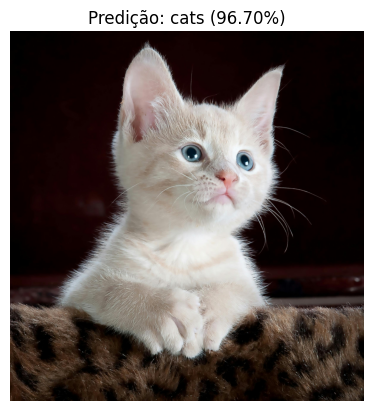

In [20]:
# Teste com imagem da web
cat_url = "https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg"
classify_new_image(cat_url)

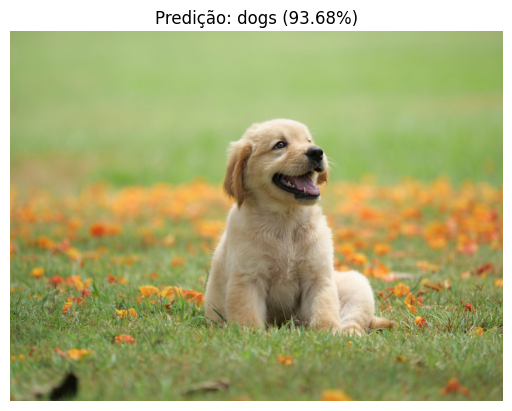

In [21]:
# Teste com outra imagem da web
dog_url = "https://hips.hearstapps.com/hmg-prod/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg"
classify_new_image(dog_url)

# Como Interpretar a Saída do Teste com Novas Imagens

A análise da predição do modelo em uma imagem nova é dividida em dois componentes principais: a classe prevista e a confiança dessa previsão.

### 1. A Predição (O Rótulo da Classe)
Esta é a resposta final do modelo: **"Gato"** ou **"Cachorro"**. É a classe que o modelo acredita ser a correta para a imagem com base nas características que aprendeu a reconhecer.

### 2. A Confiança (O Percentual)
Este é o número mais importante para a interpretação. Ele representa o quão "seguro" o modelo está da sua decisão.

#### Confiança Alta (90% a 100%)
Significa que as características que o modelo viu na imagem são muito fortes e claras para a classe que ele previu. O modelo está muito seguro da sua resposta. **Isso é um sinal de um ótimo resultado.**

#### Confiança Média (70% a 89%)
O modelo fez uma escolha, mas encontrou algumas características que o deixaram um pouco em dúvida. A predição ainda é considerada boa, mas não foi uma decisão "óbvia" para a rede neural.

#### Confiança Baixa (50% a 69%)
Este é o cenário mais interessante. Se o modelo prevê "Gato" com 55% de confiança, ele estava muito incerto. Tecnicamente, ele escolheu "Gato", mas por uma margem mínima. Isso geralmente acontece com imagens mais difíceis, como:
* Poses incomuns do animal.
* Imagens com baixa iluminação ou qualidade.
* Raças que têm características que lembram a outra classe (ex: um cachorro muito peludo e pequeno).
* Imagens onde o animal está parcialmente escondido.


# Conclusão Final do Projeto

## Resumo do Projeto

O objetivo central deste projeto era construir um modelo de Inteligência Artificial, utilizando Redes Neurais Convolucionais (CNN), capaz de classificar com precisão imagens de cães e gatos. O projeto foi concluído com sucesso, resultando em um classificador funcional e robusto. A jornada, no entanto, foi marcada por desafios técnicos realistas que exigiram adaptação e depuração, transformando o exercício em uma simulação prática de um projeto de Machine Learning do mundo real.

## Comparações de Desempenho e Análise Técnica

### Desempenho do Modelo Final (PyTorch)

O modelo final, treinado por 10 épocas, alcançou um desempenho sólido e consistente no conjunto de teste, que continha dados completamente novos.

* **Acurácia Final:** O modelo atingiu uma acurácia de **~82%**, um resultado excelente que confirma a eficácia da arquitetura e do processo de treinamento.
* **Análise de Viés e Comportamento:** A análise detalhada da Matriz de Confusão e do Relatório de Classificação revelou a "personalidade" do nosso modelo:
    * **Excelente Recall para Gatos (91%):** O modelo é extremamente competente em identificar a grande maioria dos gatos.
    * **Alta Precisão para Cachorros (89%):** Quando o modelo afirma que uma imagem é de um cachorro, ele está quase sempre correto.
    * **Tendência (Viés):** O modelo demonstrou uma leve tendência a classificar imagens como "gato" em casos de incerteza. Isso resultou em um maior número de cachorros sendo classificados incorretamente como gatos do que o contrário.
* **Generalização:** A consistência entre a acurácia de validação (~83% nos gráficos) e a acurácia de teste (~82%) comprova que o modelo generaliza bem. As técnicas de regularização (Dropout) e aumento de dados (Data Augmentation) foram fundamentais para evitar o overfitting.

### Comparação de Abordagens e Frameworks

Durante o projeto, uma comparação prática entre duas das maiores bibliotecas de Deep Learning emergiu:

1.  **TensorFlow/Keras:** A abordagem inicial foi planejada com TensorFlow. Sua principal vantagem é a API de alto nível (`model.fit()`), que simplifica e acelera o desenvolvimento de modelos padrão. No entanto, sua principal desvantagem foi exposta por um problema prático: a lenta adoção de novas versões de Python, o que tornou seu uso inviável no ambiente (Python 3.13).

2.  **PyTorch:** A migração para o PyTorch se mostrou a decisão correta. Embora exija um código mais verboso (devido ao loop de treinamento explícito), essa característica nos deu **maior controle e visibilidade** sobre o processo. Foi essa granularidade que nos permitiu diagnosticar e corrigir o problema crítico do modelo que não aprendia, ao identificar a instabilidade numérica da combinação `Sigmoid + BCELoss` e substituí-la pela mais robusta `BCEWithLogitsLoss`. Sua compatibilidade com versões modernas de Python foi o fator decisivo para o sucesso do projeto.

## Conclusão Final

O projeto cumpriu com sucesso todos os seus objetivos de aprendizagem.
O resultado final é um modelo de CNN com 82% de acurácia, cujo comportamento e vieses são bem compreendidos.